In [1]:
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt
import requests
import json


In [2]:
df = pd.read_csv("aaveExample.csv")

# Clean Up dates

df['FirstDeposit'] = df['FirstDeposit'].astype('datetime64[ns]')
df['LastWithdraw'] = df['LastWithdraw'].astype('datetime64[ns]')



In [3]:
df.head()

,Unnamed: 0,user,FirstDeposit,FirstBorrow,LastWithdraw,LastLiquidation,TotalUSDSupplied,TotalDepositsWETH,TotalWithdrawalsWETH,TotalLiquidationsWETH,...,TotalLiquidationsLUSD,TotalBorrowsLUSD,TotalRepaymentsLUSD,Total CollateralLUSD,Total Collateral USDLUSD,Total Collateral USD,End Date,TotalDaysSinceEntry,DaysUntilExit,Exit
0,0,0x1ad3b6b2df0046cef9bbbc3441790c3a600fd989,2021-03-30 05:57:28,2021-03-30 05:57:28,2021-06-12 09:30:28,NaN,509487.013270,114.90,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,164979.744755,2022-12-31 23:59:11,641,74.0,False
1,1,0x2c3e64f5077f5670caff4177fca1e182dedead3f,2022-08-25 02:31:15,2022-08-25 02:31:15,NaT,NaN,1.057695,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.780861,2022-12-31 23:59:11,128,NaN,False
2,2,0xa8b7a33f25490b8eebb10312e82403e8e9013663,2021-06-29 05:41:10,2021-06-29 05:41:10,NaT,NaN,42.350787,0.02,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,24.405800,2022-12-31 23:59:11,550,NaN,False
3,3,0x80d4ea495d4a02d84486c50bb197ba3bd3622859,2022-06-04 06:15:27,2022-06-04 06:15:27,2022-07-06 14:15:09,NaN,32435.890847,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-21.703572,2022-12-31 23:59:11,210,32.0,True
4,4,0x55d23b6a55ebac344a1a2e664e803a6880b46c83,2022-10-19 08:27:47,2022-10-19 08:27:47,2022-10-28 11:08:59,NaN,11.957777,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.355920,2022-12-31 23:59:11,73,9.0,False


In [4]:
# calc retention

# Filters - applied when calculating retention 
AssetDeposited = ['WETH']
minDepositValue = 10000


Days = range(500)
reducedDf = df[df['TotalUSDSupplied'] > minDepositValue]
retentionList = []

for day in Days :
    reducedDf = reducedDf[reducedDf['TotalDaysSinceEntry'] > day]
    n = len(reducedDf) 
    exits = (reducedDf[reducedDf.Exit == True])
    retention = 1 - sum(exits['DaysUntilExit'] < day) / len(reducedDf)
    retentionList.append(retention)

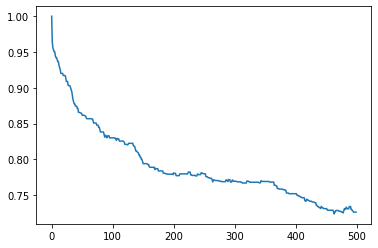

In [5]:
plt.plot(retentionList)

In [74]:
date = pd.Timestamp('2022-10-01')
# New Users 
minDepositValue = 100000

newUsers = list(df[(df['FirstDeposit'] > date) & (df['TotalUSDSupplied'] >= minDepositValue) & (df['Exit'] == False)]['user'])
lostUsers = list(df[(df['LastWithdraw'] > date) & (df['TotalUSDSupplied'] >= minDepositValue) & (df['Exit'] == True)]['user'])

In [75]:
userDf = pd.read_csv("AAVEusers.csv")

In [76]:
### New User Portfolios

newApps = userDf[userDf.User.isin(newUsers)]

In [53]:
### Lost User Portfolios

userDf[userDf.User == lostUsers[2]]

,Unnamed: 0,User,Name,Chain,Value
5226,5226,0xd35db3b19c8c2a60b8613e5b30aadcd290c99e75,GrizzlyFi,bsc,920688.112760
5227,5227,0xd35db3b19c8c2a60b8613e5b30aadcd290c99e75,Venus,bsc,84016.050593
5228,5228,0xd35db3b19c8c2a60b8613e5b30aadcd290c99e75,Compound,eth,6.657349
5229,5229,0xd35db3b19c8c2a60b8613e5b30aadcd290c99e75,Damm Finance,eth,0.000000
5230,5230,0xd35db3b19c8c2a60b8613e5b30aadcd290c99e75,DeFi Franc,eth,0.011439
5231,5231,0xd35db3b19c8c2a60b8613e5b30aadcd290c99e75,Geist,ftm,461379.629425


In [54]:
def totalTVL(row):
    return userDf[userDf.User == row['user']]['Value'].sum()

def totalTVLAAVE(row):
    return userDf[(userDf.User == row['user']) & (userDf.Name == 'Aave V2')]['Value'].sum()

In [55]:
df['totalTVL'] = df.apply(totalTVL, axis=1)
df['totalTVLAAVE'] = df.apply(totalTVLAAVE, axis=1)

df['Percent In AAVE'] = df['totalTVLAAVE'] / df['totalTVL']

In [56]:
# Filters - applied when running analysis retention 
minTVL = 10000

reducedDf = df[df['totalTVL'] > minTVL]



In [57]:
topUsers = df.nlargest(5,['totalTVLAAVE'])
cols = ['user', 'FirstDeposit', 'totalTVLAAVE' ,'totalTVL', 'Percent In AAVE']
topUsers[cols]

,user,FirstDeposit,totalTVLAAVE,totalTVL,Percent In AAVE
406,0x645c4c0c95c1aa6ef25d12f4a25038ca9b0c6cc7,2022-11-07 01:40:23,1.722756e+07,1.722756e+07,1.000000
877,0xf89a2234f442ce862443f01c3998701a4cc4a3e3,2022-04-12 21:39:34,6.302461e+06,6.302461e+06,1.000000
21,0x13e382dfe53207e9ce2eeeab330f69da2794179e,2022-06-25 00:17:10,4.867078e+06,2.742179e+07,0.177489
556,0xdc77b2c59db1b02f988e8e08a60fbe9139447cc3,2022-08-13 18:27:10,3.490881e+06,5.992164e+06,0.582574
996,0xa5d223c176daab154a3134369d1c0478c5e6fecf,2021-05-30 13:36:56,3.250865e+06,1.986928e+07,0.163613


In [78]:
df[df.user.isin(lostUsers)][cols]

,user,FirstDeposit,totalTVLAAVE,totalTVL,Percent In AAVE
80,0x7a0af73e4c08a4a46513e8b7fea726fb8d499614,2022-10-04 20:26:59,0.188882,1.888820e-01,1.0
412,0x64bade3ea5ffc64cfb776f55cf82086b9429a5ee,2022-12-12 19:30:47,0.000000,7.573103e+01,0.0
561,0xd35db3b19c8c2a60b8613e5b30aadcd290c99e75,2022-09-30 23:18:59,0.000000,1.466090e+06,0.0
783,0x49ae763ed846db9a69a639732caa320fad1d5799,2022-10-06 16:13:23,0.000000,1.569588e+04,0.0


In [79]:
df[df.user.isin(newUsers)][cols]

,user,FirstDeposit,totalTVLAAVE,totalTVL,Percent In AAVE
357,0xf7626459234e9249808a06aa08dc6b67c8e0a2fc,2022-11-14 17:41:47,1.613568e-15,2.807902e+06,5.746526e-22
406,0x645c4c0c95c1aa6ef25d12f4a25038ca9b0c6cc7,2022-11-07 01:40:23,1.722756e+07,1.722756e+07,1.000000e+00
478,0x42c0eeb504d374d7cff5865c982cee7d4a59d77e,2022-11-24 03:59:47,1.170800e-02,1.170800e-02,1.000000e+00
518,0x064d3230f753d8c14e06cf491fe2f1a3d2ccd5dd,2022-11-13 21:35:23,1.017033e+05,1.747232e+05,5.820827e-01
587,0x63158ffa98f89a49a50a6e70279d8fc55692daed,2022-11-05 17:46:23,6.038481e+05,6.038481e+05,1.000000e+00
667,0x096232202dd7b86fddff038189dfe0f1861bb028,2022-10-05 15:19:23,5.228891e+05,5.234382e+05,9.989510e-01
917,0x0960cbefa076b248664c079174126ff9554ce809,2022-12-03 08:24:35,1.776000e-02,6.143192e+00,2.891005e-03


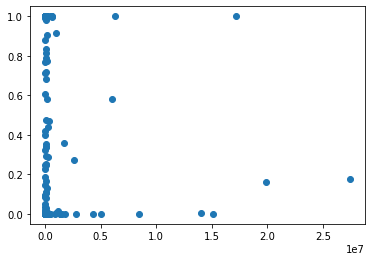

In [58]:
plt.scatter(reducedDf['totalTVL'], reducedDf['Percent In AAVE'])

(array([89.,  8.,  7.,  6.,  4.,  2.,  2.,  5.,  3., 26.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

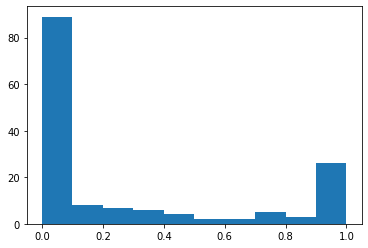

In [59]:
plt.hist(reducedDf['Percent In AAVE'])

In [60]:
newUsers

['0xf7626459234e9249808a06aa08dc6b67c8e0a2fc',
 '0x645c4c0c95c1aa6ef25d12f4a25038ca9b0c6cc7',
 '0x42c0eeb504d374d7cff5865c982cee7d4a59d77e',
 '0x064d3230f753d8c14e06cf491fe2f1a3d2ccd5dd',
 '0x63158ffa98f89a49a50a6e70279d8fc55692daed',
 '0x096232202dd7b86fddff038189dfe0f1861bb028',
 '0x0960cbefa076b248664c079174126ff9554ce809']

In [61]:
otherApps = list(userDf['Name'].unique())

exclude = ['Aave V2', 'Aave V3']
for item in exclude : 
    otherApps.remove(item)

compDf = pd.DataFrame({'Name' : otherApps})

lostUserDf = userDf[userDf.User.isin(lostUsers)]
newUserDf = userDf[userDf.User.isin(newUsers)]


In [73]:
lostUsers

<function __main__.lostUsers(row)>

In [86]:
compDf

,Name,TVLFromSharedUsers,nUsers,tvlInAAVE,lostTVL,compTVLGained,lostUsers,newUsers,compTVLLost,compTVLNew
0,GMX,3.155064e+05,149,208676.485661,0.000000e+00,0.000000,0,0,0.0,0.0
1,Wonderland,2.117823e+05,63,598416.167394,0.000000e+00,0.000000,0,0,0.0,0.0
2,Venus,2.006059e+05,53,181617.447387,3.582859e+06,84016.051002,2,0,0.0,0.0
3,Adamant,1.810417e+03,21,12724.704626,0.000000e+00,0.000000,0,0,0.0,0.0
4,Klima DAO,2.861680e+03,81,15431.465657,0.000000e+00,0.000000,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
548,Voltage,2.649618e-06,1,0.000000,0.000000e+00,0.000000,0,0,0.0,0.0
549,Unifi Protocol,6.376570e-06,1,0.000000,0.000000e+00,0.000000,0,0,0.0,0.0
550,Dot Dot Finance,7.528391e+01,1,46.555261,0.000000e+00,0.000000,0,0,0.0,0.0
551,Valas,2.480448e-01,1,46.555261,0.000000e+00,0.000000,0,0,0.0,0.0


In [80]:
df[df.user.isin(lostUsers)]

,Unnamed: 0,user,FirstDeposit,FirstBorrow,LastWithdraw,LastLiquidation,TotalUSDSupplied,TotalDepositsWETH,TotalWithdrawalsWETH,TotalLiquidationsWETH,...,Total CollateralLUSD,Total Collateral USDLUSD,Total Collateral USD,End Date,TotalDaysSinceEntry,DaysUntilExit,Exit,totalTVL,totalTVLAAVE,Percent In AAVE
80,80,0x7a0af73e4c08a4a46513e8b7fea726fb8d499614,2022-10-04 20:26:59,2022-10-04 20:26:59,2022-11-08 23:16:35,NaN,7.727655e+05,0.00,0.000000,0.0,...,0.0,0.0,-3588.055189,2022-12-31 23:59:11,88,35.0,True,1.888820e-01,0.188882,1.0
412,412,0x64bade3ea5ffc64cfb776f55cf82086b9429a5ee,2022-12-12 19:30:47,2022-12-12 19:30:47,2022-12-31 00:34:23,NaN,6.652763e+05,0.00,0.000000,0.0,...,0.0,0.0,-388.039204,2022-12-31 23:59:11,19,18.0,True,7.573103e+01,0.000000,0.0
561,561,0xd35db3b19c8c2a60b8613e5b30aadcd290c99e75,2022-09-30 23:18:59,2022-09-30 23:18:59,2022-11-04 04:36:47,NaN,2.917583e+06,560.75,560.829691,0.0,...,0.0,0.0,-333.628124,2022-12-31 23:59:11,92,34.0,True,1.466090e+06,0.000000,0.0
783,783,0x49ae763ed846db9a69a639732caa320fad1d5799,2022-10-06 16:13:23,2022-10-06 16:13:23,2022-11-09 00:29:59,NaN,9.364006e+06,0.00,0.000000,0.0,...,0.0,0.0,-587.456076,2022-12-31 23:59:11,86,33.0,True,1.569588e+04,0.000000,0.0


In [81]:
lostUserDf.nlargest(5, ['Value'])

,Unnamed: 0,User,Name,Chain,Value
5226,5226,0xd35db3b19c8c2a60b8613e5b30aadcd290c99e75,GrizzlyFi,bsc,920688.112760
5231,5231,0xd35db3b19c8c2a60b8613e5b30aadcd290c99e75,Geist,ftm,461379.629425
5227,5227,0xd35db3b19c8c2a60b8613e5b30aadcd290c99e75,Venus,bsc,84016.050593
6992,6992,0x49ae763ed846db9a69a639732caa320fad1d5799,Convex,eth,12325.918568
6989,6989,0x49ae763ed846db9a69a639732caa320fad1d5799,Aave V3,avax,3369.748955


In [65]:
def compTVL(row):
    return userDf[userDf.Name == row['Name']]['Value'].sum()

def compUsers(row):
    return len(userDf[userDf.Name == row['Name']])

def tvlInAAVE(row):
    userList = list(userDf[userDf.Name == row['Name']]['User'])
    return userDf[(userDf.User.isin(userList)) & (userDf.Name.isin(exclude))]['Value'].sum()

def lostTVL(row): 
    userList = list(lostUserDf[lostUserDf.Name == row['Name']]['User'])
    return df[(df.user.isin(userList))]['TotalUSDSupplied'].sum()
    
def compTVLGained(row):    
    return lostUserDf[lostUserDf.Name == row['Name']]['Value'].sum()
    
def lostUsers(row):
    return len(lostUserDf[lostUserDf.Name == row['Name']])
    

def compTVLLost(row):    
    return newUserDf[newUserDf.Name == row['Name']]['Value'].sum()
    
def countNewUsers(row):
    return len(newUserDf[newUserDf.Name == row['Name']])
        
    
    
compDf['TVLFromSharedUsers'] =  compDf.apply(compTVL, axis=1)      
compDf['nUsers'] =  compDf.apply(compUsers, axis=1)      
compDf['tvlInAAVE'] = compDf.apply(tvlInAAVE, axis=1) 

compDf['lostTVL'] =  compDf.apply(lostTVL, axis=1) 
compDf['compTVLGained'] =  compDf.apply(compTVLGained, axis=1) 
compDf['lostUsers'] =  compDf.apply(lostUsers, axis=1) 

compDf['newUsers'] =  compDf.apply(countNewUsers, axis=1) 
compDf['compTVLNew'] =  compDf.apply(compTVLLost, axis=1) 



<BarContainer object of 5 artists>

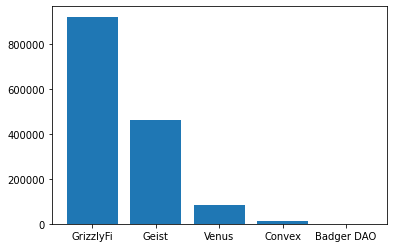

In [30]:
# Of competitors what are N largest protocols that users are using (by TVL)
largestComps = compDf.nlargest(5,['compTVLGained'])


plt.bar(largestComps['Name'], largestComps['compTVLGained'])

<BarContainer object of 5 artists>

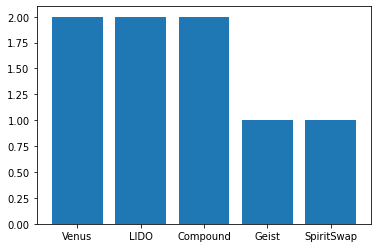

In [34]:
# Of competitors what are N largest protocols that users are using (by TVL)
largestComps = compDf.nlargest(5,['lostUsers'])


plt.bar(largestComps['Name'], largestComps['lostUsers'])

<BarContainer object of 5 artists>

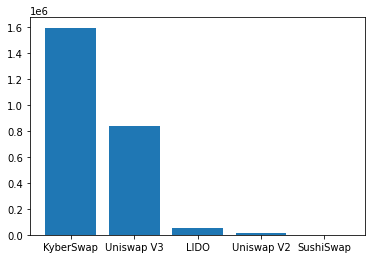

In [66]:
# From New Users What are Largest Protocols being Used 
largestComps = compDf.nlargest(5,['compTVLNew'])


plt.bar(largestComps['Name'], largestComps['compTVLNew'])

<BarContainer object of 5 artists>

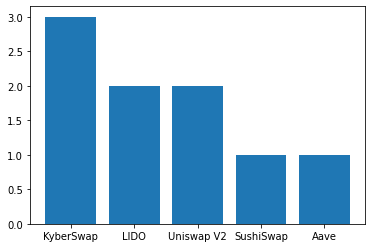

In [67]:
# OF new users what are most common apps being used
largestComps = compDf.nlargest(5,['newUsers'])


plt.bar(largestComps['Name'], largestComps['newUsers'])

In [ ]:
# Of competitors what are N largest protocols that users are using (by TVL)
largestComps = compDf.nlargest(5,['lostUsers'])


plt.bar(largestComps['Name'], largestComps['lostUsers'])

<BarContainer object of 5 artists>

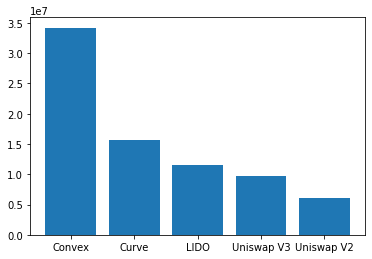

In [32]:
largestShared = compDf.nlargest(5,['TVLFromSharedUsers'])

plt.bar(largestShared['Name'], largestShared['TVLFromSharedUsers'])

<BarContainer object of 5 artists>

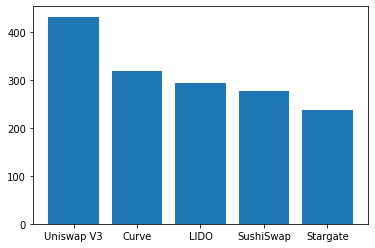

In [33]:
largestShared = compDf.nlargest(5,['nUsers'])

plt.bar(largestShared['Name'], largestShared['nUsers'])

<BarContainer object of 2 artists>

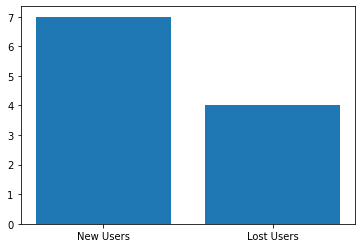

In [15]:
plt.bar(['New Users', 'Lost Users'], [len(newUsers), len(lostUsers)])

In [82]:
userDf[userDf.User.isin(lostUsers)]

,Unnamed: 0,User,Name,Chain,Value
521,521,0x7a0af73e4c08a4a46513e8b7fea726fb8d499614,Aave V2,eth,1.888820e-01
522,522,0x7a0af73e4c08a4a46513e8b7fea726fb8d499614,LIDO,eth,1.616860e-15
3898,3898,0x64bade3ea5ffc64cfb776f55cf82086b9429a5ee,Badger DAO,eth,6.364489e+01
3899,3899,0x64bade3ea5ffc64cfb776f55cf82086b9429a5ee,AutoFarm,boba,1.429303e-16
3900,3900,0x64bade3ea5ffc64cfb776f55cf82086b9429a5ee,Venus,bsc,4.086105e-04
3901,3901,0x64bade3ea5ffc64cfb776f55cf82086b9429a5ee,Compound,eth,8.623277e-01
3902,3902,0x64bade3ea5ffc64cfb776f55cf82086b9429a5ee,SpiritSwap,ftm,7.093745e+00
3903,3903,0x64bade3ea5ffc64cfb776f55cf82086b9429a5ee,Uniswap V2,eth,4.129660e+00
3904,3904,0x64bade3ea5ffc64cfb776f55cf82086b9429a5ee,xToken,eth,1.779806e-12
5226,5226,0xd35db3b19c8c2a60b8613e5b30aadcd290c99e75,GrizzlyFi,bsc,9.206881e+05


<BarContainer object of 2 artists>

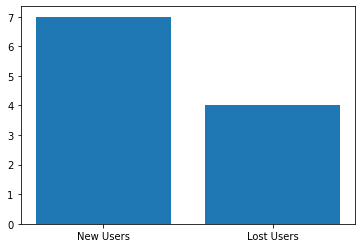

In [83]:
plt.bar(['New Users', 'Lost Users'], [len(newUsers), len(lostUsers)])

TypeError: unhashable type: 'numpy.ndarray'

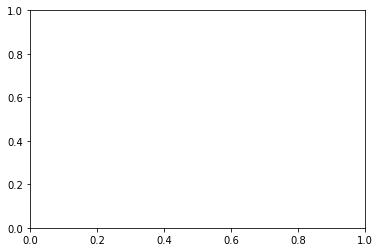

In [84]:
plt.plot(compDf.nlargest(5,['TVLFromSharedUsers']))

In [19]:
# where have lost users gone ??? 

compDf

,Name
0,GMX
1,Wonderland
2,Venus
3,Adamant
4,Klima DAO
...,...
548,Voltage
549,Unifi Protocol
550,Dot Dot Finance
551,Valas
